[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Shells_Mannheim_Multihalle_Size.ipynb)

In [ ]:
!pip install JaxSSO

In [1]:

import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon
from jax import grad,value_and_grad

/tmp/ipykernel_4094451/3613907660.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Import the geometry data

In [2]:
local_path = 'https://raw.githubusercontent.com/GaoyuanWu/JaxSSO/main/Examples/Data/Mannheim_Quad/' #path of the file
df = pd.read_csv(local_path + 'cnct.csv',header=None) #Connectivity matrix
n_ele = (df.to_numpy().shape[0]+1)//4 #number of elements
cnct = np.zeros((n_ele,4),dtype=int)
for i in range(n_ele):
    cnct[i,:] = df.to_numpy().ravel()[i*4:i*4+4]

df2 = pd.read_csv(local_path + 'crd_x.csv',header=None)
df3 = pd.read_csv(local_path + 'crd_y.csv',header=None)
df4 = pd.read_csv(local_path + 'crd_z.csv',header=None)
x_nodes = df2.to_numpy().ravel()
y_nodes = df3.to_numpy().ravel()
z_nodes = df4.to_numpy().ravel()
df5 = pd.read_csv(local_path + 'bc_node.csv',header=None)
bc_nodes =df5.to_numpy().ravel()
n_node = x_nodes.shape[0] #number of nodes
#Normalize the coordinates
xs = x_nodes-min(x_nodes)
ys = y_nodes-min(y_nodes)
x_span = max(xs) - min(xs)
y_span = max(ys)-min(ys)

zs = 0.001*np.array([1.16650095, 3.62250162, 0.63325483, 0.77655229, 1.31265331,
       1.68669962, 1.3108091 , 0.70937376, 0.75285485, 0.75147257,
       3.72966479, 3.33904017, 3.2852944 , 3.68587899, 3.94246337,
       3.28325979, 0.40413206, 0.50044157, 0.66623939, 1.16997263,
       1.38378168, 0.75926339, 0.93162776, 1.10626873, 0.62429206,
       0.48496525, 0.52765893, 0.37263336, 0.48602284, 0.37234998,
       0.62823902, 1.11117905, 1.51770931, 1.83650319, 1.33985457,
       1.35554889, 1.85021962, 2.24377223, 2.54619062, 2.07800999,
       2.11718138, 2.57550883, 2.93027954, 3.18962572, 2.76603404,
       2.84413549, 3.24312633, 3.53590915, 3.72819718, 3.35961348,
       3.49551447, 3.81602071, 4.02678719, 4.13139956, 3.82381225,
       4.03920535, 4.26486464, 4.37663276, 4.37626722, 4.13169936,
       4.4501666 , 4.56733296, 4.56619375, 4.44693168, 4.26387636,
       4.70967206, 4.70757647, 4.58283105, 4.3342407 , 4.20815888,
       4.80494237, 4.67590867, 4.42017962, 4.03530249, 3.95912661,
       4.72901498, 4.46859995, 4.07778906, 3.5529028 , 3.51744802,
       4.48074946, 4.08768435, 3.56068427, 2.89479812, 2.88902319,
       4.06484793, 3.54068514, 2.87879948, 2.07288733, 2.08401889,
       3.49174221, 2.84016068, 2.0462311 , 1.10224328, 1.11583318,
       2.77720325, 2.00296643, 1.08024217, 0.        , 0.        ,
       1.94152254, 1.04909232, 0.        , 1.00793791, 0.        ,
       0.95605401, 0.        , 0.89348999, 0.        , 0.82272567,
       0.        , 0.        , 0.        , 0.        , 0.81904075,
       0.        , 0.88612716, 0.        , 0.94339533, 0.        ,
       0.98836827, 0.        , 1.02138229, 0.        , 1.0441208 ,
       0.        , 1.05915698, 0.        , 1.0697462 , 0.        ,
       1.07933857, 0.        , 1.09038619, 0.        , 1.10285587,
       0.        , 1.11533725, 0.        , 1.12617231, 0.        ,
       1.13396352, 0.        , 1.13765824, 0.        , 1.13645844,
       0.        , 1.12969115, 0.        , 1.11668911, 0.        ,
       1.09668975, 0.        , 1.06874455, 0.        , 1.03162437,
       0.        , 0.98370166, 0.        , 0.92278552, 0.        ,
       0.8458956 , 0.        , 0.74908755, 0.        , 0.        ,
       0.        , 0.        , 0.31018502, 0.        , 0.27900664,
       0.        , 0.26406092, 0.        , 0.25720765, 0.        ,
       0.25454901, 0.        , 0.34355399, 0.33977273, 0.25720616,
       0.25454852, 0.        , 0.        , 0.26405546, 0.        ,
       0.27898629, 0.        , 0.31010909, 0.        , 0.        ,
       0.        , 0.        , 0.73926761, 0.        , 0.82625715,
       0.        , 0.88838222, 0.        , 0.92854509, 0.        ,
       0.94861997, 0.        , 0.94959274, 0.        , 0.93174535,
       0.        , 0.89478731, 0.        , 0.83800111, 0.        ,
       0.76058996, 0.        , 0.66272225, 0.        , 0.54849585,
       0.        , 0.43296673, 0.        , 0.35046502, 0.        ,
       0.30178512, 0.        , 0.27574564, 0.        , 0.26253666,
       0.        , 0.25603213, 0.        , 0.25288289, 0.        ,
       0.25137332, 0.        , 0.25065481, 0.        , 0.25031623,
       0.        , 0.25016191, 0.        , 0.25010216, 0.        ,
       0.33356257, 0.33347789, 0.2501623 , 0.25010229, 0.        ,
       0.        , 0.25031766, 0.        , 0.25066013, 0.        ,
       0.25139318, 0.        , 0.25295702, 0.        , 0.25630877,
       0.        , 0.2635691 , 0.        , 0.27959876, 0.        ,
       0.31616516, 0.        , 0.        , 0.        , 0.        ,
       0.85335037, 0.        , 0.9271843 , 0.        , 0.98567187,
       0.        , 1.03159921, 0.        , 1.06683462, 0.        ,
       1.09269767, 0.        , 1.11010191, 0.        , 1.11962301,
       0.        , 1.12153544, 0.        , 0.        , 2.08018801,
       2.0614203 , 2.86153714, 2.02718748, 2.81159037, 3.45338297,
       2.73758722, 3.35870024, 3.84691358, 3.23025049, 3.69500195,
       4.03788288, 3.49829417, 3.81782768, 4.02775699, 3.54071001,
       3.73095788, 3.82470701, 3.36399083, 3.4456919 , 3.44427856,
       2.98312452, 2.98132997, 2.90968577, 2.42156437, 2.36509893,
       2.2519674 , 1.71051151, 1.63205997, 1.51071209, 1.74967538,
       1.75133899, 2.42348652, 2.37125154, 1.71593466, 2.91532302,
       2.77625852, 2.26359529, 3.19732386, 2.94166939, 2.56212524,
       3.25006398, 2.85291565, 2.59049783, 3.06361642, 2.5063387 ,
       2.34081772, 2.6370167 , 1.9072237 , 1.81723731, 1.97637492,
       1.70304828, 1.56028714, 2.13430156, 1.87893689, 2.26643806,
       1.56455958, 1.86752561, 2.09746833, 1.37496982, 1.52996051,
       1.64273611, 1.17513652, 0.37199411, 0.41426316, 0.35170221,
       0.34204231, 0.33745945, 0.3352889 , 0.33426301, 0.33378153,
       0.37511394, 0.42243341, 0.35336274, 1.54504268, 1.69487817,
       2.33128772, 1.81373007, 2.50228919, 3.05995243, 2.63751988,
       3.23120388, 3.69629176, 3.36438479, 3.85257665, 4.21297763,
       3.96998575, 4.34329526, 4.58882451, 4.43472649, 4.68549745,
       4.80828762, 4.7434845 , 4.86637193, 4.86133005, 4.88571889,
       4.87832424, 4.74355458, 4.85602679, 4.71946298, 4.45649229,
       4.65511161, 4.39424211, 4.00786328, 4.29083459, 3.91395419,
       3.4115931 , 3.77885914, 3.29680607, 2.68742611, 3.14267926,
       2.56750593, 1.85993863, 2.41331304, 1.75612149, 2.21988508,
       1.6285136 , 1.98100542, 1.47789117, 2.6900416 , 2.37287915,
       1.97566399, 2.67813891, 2.20451392, 1.6154059 , 1.4718966 ,
       2.38218022, 1.73241923, 2.51428766, 1.82202881, 2.60613857,
       1.8863734 , 2.663854  , 1.92927728, 2.6954535 , 1.95609425,
       2.71222798, 1.97382258, 2.72970938, 1.99055522, 2.76409325,
       2.01268367, 2.8082731 , 2.03903337, 2.85285754, 2.06565416,
       2.89103718, 2.0887218 , 2.91853121, 2.10535688, 2.93267785,
       2.11354433, 2.93165093, 2.11181769, 2.91391715, 2.09895038,
       2.87787065, 2.07370887, 2.82157199, 2.03465868, 2.74253519,
       1.97999742, 1.9073846 , 3.46455678, 3.53561793, 4.05284764,
       3.58052997, 4.10439374, 4.49059894, 4.12693174, 4.51312437,
       4.76480301, 4.50349713, 4.75021762, 4.86670971, 4.69919397,
       4.80820889, 4.79294354, 4.70732165, 4.68576022, 4.54713114,
       4.52897789, 4.39015148, 4.14134424, 4.17648598, 3.93886508,
       3.59666539, 3.67429806, 3.3595914 , 2.94307299, 3.05766251,
       3.33621146, 2.91083341, 3.53538519, 3.08013637, 3.66266864,
       3.19337255, 3.72465555, 3.25787997, 3.72862452, 3.28297111,
       4.08278241, 4.05432575, 4.35488708, 4.29676603, 4.1333173 ,
       4.47786733, 4.27938581, 3.95185894, 3.84798732, 3.47979906,
       3.41044158, 4.03359689, 3.53737151, 4.09065742, 3.57838626,
       4.1220178 , 3.60031824, 3.60152439, 4.46196205, 4.38783302,
       4.60972066, 4.55893015, 4.31440305, 4.0305946 , 3.89585762])
xs = xs
ys = ys

xs_const = xs
ys_const = ys

In [3]:
#Properties, design nodes, load;
t = 0.15
E = 1e10
nu = 0.3 
design_nodes = []
non_design_nodes = []
for i in range(n_node):
    if i in bc_nodes:
      non_design_nodes.append(i)
      
    else:
      design_nodes.append(i)
      zs[i] = np.random.uniform(0.5,0.51)#random_z
design_nodes = np.asarray(design_nodes)
load = 50000



In [4]:
raw_cnct_bar = []
raw_cnct = df.to_numpy().ravel()
for i in range(n_ele):
  raw_cnct_bar.append([raw_cnct[i*4],raw_cnct[i*4+1]])
  raw_cnct_bar.append([raw_cnct[i*4+1],raw_cnct[i*4+2]])
  raw_cnct_bar.append([raw_cnct[i*4+2],raw_cnct[i*4+3]])
  raw_cnct_bar.append([raw_cnct[i*4+3],raw_cnct[i*4]])

raw_cnct_bar = np.asarray(raw_cnct_bar) # with duplication

cnct_bar = []
for i in range(n_node):
  temp_list = []
  rows_i = np.argwhere(raw_cnct_bar==i)[:,0]
  cols_i = np.argwhere(raw_cnct_bar==i)[:,1]
  for j in range(rows_i.shape[0]):
    if cols_i[j] == 0:
      if raw_cnct_bar[rows_i[j],1] not in temp_list:
        temp_list.append(i)
        temp_list.append(raw_cnct_bar[rows_i[j],1])
    else:
      if raw_cnct_bar[rows_i[j],0] not in temp_list:
        temp_list.append(i)
        temp_list.append(raw_cnct_bar[rows_i[j],0])
  raw_cnct_bar = np.delete(raw_cnct_bar,rows_i,0)
  cnct_bar.extend(temp_list)
cnct_bar = np.asarray(cnct_bar,dtype=int)
cnct_network = cnct_bar.reshape(cnct_bar.shape[0]//2,2)

n_ele_bar = cnct_network.shape[0]
x_ele = np.zeros((n_ele_bar,2)) #x of the elements
y_ele = np.zeros((n_ele_bar,2))
z_ele = np.zeros((n_ele_bar,2))

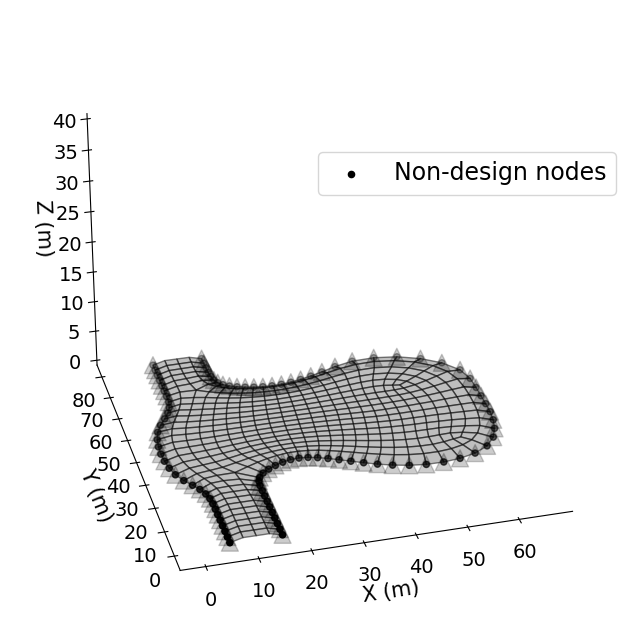

In [5]:
%matplotlib inline


for i in range(n_ele_bar):
  x_ele[i,:] = [xs[cnct_network[i,0]],xs[cnct_network[i,1]]]
  y_ele[i,:] = [ys[cnct_network[i,0]],ys[cnct_network[i,1]]]
  z_ele[i,:] = [zs[cnct_network[i,0]],zs[cnct_network[i,1]]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
#  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')
all_corners = []

for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(0.5)
tdco.set_facecolor('grey')
tdco.set_edgecolor('black')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

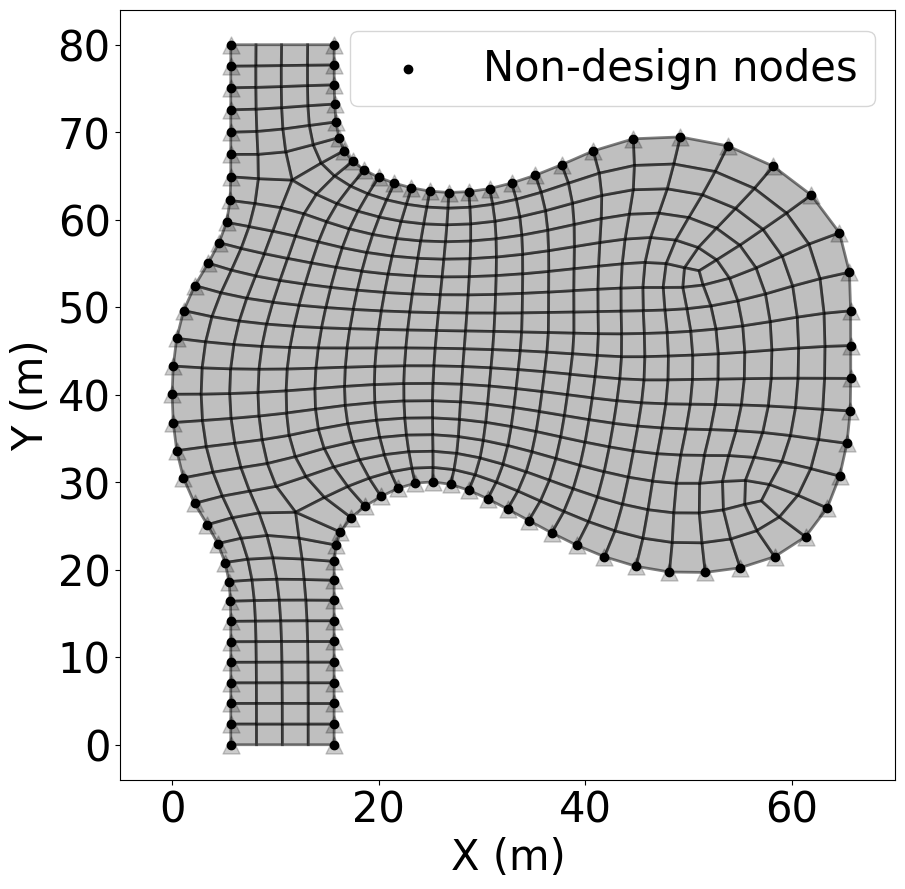

In [6]:

fig,ax = plt.subplots(figsize=(10,10))
plt.xlim(-5,70)
#plt.ylim(-5,30)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    this_poly.set_alpha(0.5)
    this_poly.set_facecolor('grey')
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')

plt.legend(fontsize=30)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

# Define hat filter, conduct shape optimization

In [7]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))


Create filter mapping matrix $B_{ij}$

$z_i = B_{ij}p_j$

$\frac{df}{dp_j} = B_{ij}\frac{df}{dz_i}$

In [8]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,10)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [9]:
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,1,1])
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()

# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [11]:
C_hist = []
def objective_filter(x,sso_model=sso_model):
    p = zs.copy()
    p[design_nodes]=x
    z = (B_ij@p)[design_nodes]
    sso_model.update_nodeparameter(z) # Update the model
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    C_hist.append(C)
    return C,np.asarray((sens@B_ij[design_nodes])[design_nodes],dtype=float)#sens_params

In [12]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = sso_model.nodeparameters_values #initial parameters 
opt = optimization.Optimization(n_x,method='GD')
opt.set_objective(objective_filter) #objective function
opt.set_maxiter(200) #max iteration
opt.set_step_size(1e-1) #step size
opt.set_GD_normalized(True) #normalized
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 17573176.23719143
Step 1, objective = 9653070.373716159
Step 2, objective = 5786044.097692659
Step 3, objective = 3787460.535457464
Step 4, objective = 2850531.825999636
Step 5, objective = 2327851.248372982
Step 6, objective = 1932573.6623510462
Step 7, objective = 1674310.3003937367
Step 8, objective = 1484193.1219754969
Step 9, objective = 1329669.1867066673
Step 10, objective = 1197555.0878638509
Step 11, objective = 1085272.560788666
Step 12, objective = 987205.0755714759
Step 13, objective = 902277.4091447257
Step 14, objective = 825925.5173242942
Step 15, objective = 760049.7678835317
Step 16, objective = 698271.8473394418
Step 17, objective = 648007.5235329509
Step 18, objective = 594204.5648914411
Step 19, objective = 561905.6998053568
Step 20, objective = 531805.6655620141
Step 21, objective = 511757.7683945493
Step 22, objective = 487067.1031734159
Step 23, objective = 470013.3601140814
Step 24, objective = 448443.5409644111
Step 25, objective = 433688.03

In [13]:
zs[design_nodes] = x_opt
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

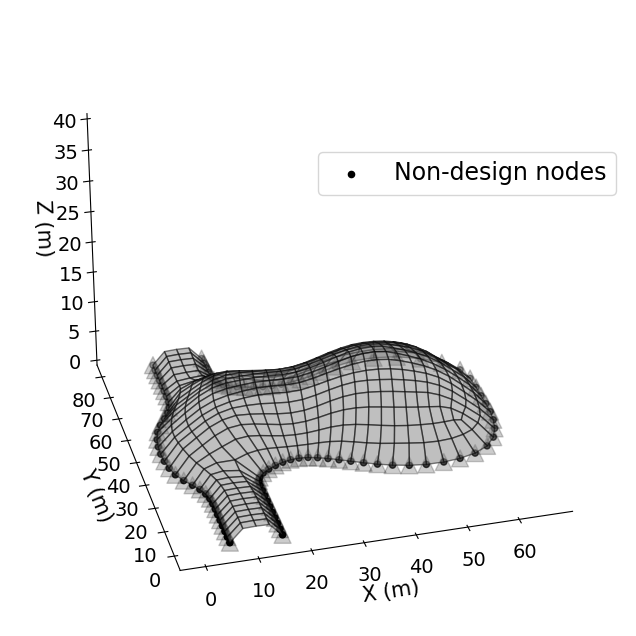

In [14]:
%matplotlib inline


for i in range(n_ele_bar):
  x_ele[i,:] = [xs[cnct_network[i,0]],xs[cnct_network[i,1]]]
  y_ele[i,:] = [ys[cnct_network[i,0]],ys[cnct_network[i,1]]]
  z_ele[i,:] = [zs_filtered[cnct_network[i,0]],zs_filtered[cnct_network[i,1]]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(0.5)
tdco.set_facecolor('grey')
tdco.set_edgecolor('black')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

# Based on the shape optimization result, create FE model and SSO_model for size optimization

In [15]:
zs=zs_filtered.copy()

In [16]:
#Create model
model = Model.Model() #model for sensitivity analysis


#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,1,1])
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()

# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [17]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
ele_A = [] #calculate the length of every member
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 0) # element object
    sso_model.add_eleparameter(eleparameter)
    
    quad = model.quads[eletag]

    i_nodeTag = quad.i_nodeTag #i-node's tag
    j_nodeTag = quad.j_nodeTag #i-node's tag
    m_nodeTag = quad.m_nodeTag #i-node's tag
    n_nodeTag = quad.n_nodeTag #i-node's tag
    
    #Crds
    crds = []
    crds.extend(model.nodes[i_nodeTag])
    crds.extend(model.nodes[j_nodeTag])
    crds.extend(model.nodes[m_nodeTag])
    crds.extend(model.nodes[n_nodeTag])
    
    temp_A = quad.A(crds)
    ele_A.append(temp_A)

#Initial the parameters
sso_model.initialize_parameters_values()
ele_A = np.array(ele_A)

# Define objective function: material volume with penalization

In [18]:
#W(A): total volume
def volume(t):
    '''
    Volume and penalty
    '''
    
    return ele_A.T@t + penalty(t)
def penalty(t):
    '''
    Limit the minimum area
    '''
    threshold = 0.05
    return jnp.sum(jnp.where(t<threshold,((threshold-t)/threshold),0))
    
#C(A): violation of displacement
def user_obj(sso_model,u,u_max):
    u_z = jnp.abs(u[design_nodes*6+2]) #Z-displacement
    n_uz = u_z/u_max-1 #normalize
    c = jnp.sum(jnp.where(n_uz>0,n_uz,0))
    return c
sso_model.set_objective(objective='user',func=user_obj,func_args=(0.015,))

In [19]:
eps1 = 1
eps2 = 1
i = 0
W_list = []#Storing the total weight
pen_list = []
SE_list = []#Storing the strain energy
u_max_list = []#Storing the maximum displacement along Z

In [20]:
def objective(A,sso_model=sso_model):
    sso_model.update_eleparameter(A) # Update the model
    c,grad_c = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    W,grad_W = value_and_grad(volume)(sso_model.parameter_values) #Volume/weight
    pen = penalty(sso_model.parameter_values) #Volume/weight
    pen_list.append(pen)
    W_list.append(W)
    SE_list.append(sso_model.params_c(sso_model.parameter_values,which_solver='sparse',enforce_scipy_sparse = True))
    u_max = np.max(np.abs(sso_model.params_u(sso_model.parameter_values,which_solver='sparse',enforce_scipy_sparse = True))[design_nodes*6+2])
    u_max_list.append(u_max)
    #p,grad_p = 
    kappa = 1+0.015#1/n_node #learning parameter of eps1
    global i,eps1
    if c>0 or pen>0:
        eps1 = (1/kappa)*eps1
    else:
        eps1 = (kappa)*eps1
    print('Displacement violation:',c,'  Area penalty',pen,' Volome and penalty',W)
    i+=1
    obj = (1+eps1*c)**eps2 * W 
    
    sens = eps2*(1+eps1*c)**(eps2-1)*grad_c*W + (1+eps1*c)**(eps2)*grad_W
    return obj,sens #sens_params

# Conduct size optimization

In [21]:
n_A = sso_model.parameter_values.shape[0] #number of parameters
A_ini = sso_model.parameter_values #initial parameters 
opt = optimization.Optimization(n_A,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(1000) #max iteration
opt.set_step_size(1e-3) #step size
opt.set_GD_normalized(True) #normalized
A_opt = opt.optimize(A_ini,log=True)

Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 513.5566994555451
Step 0, objective = 513.5566994555451
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 511.95662943606794
Step 1, objective = 511.95662943606794
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 510.35655941659076
Step 2, objective = 510.35655941659076
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 508.7564893971137
Step 3, objective = 508.7564893971137
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 507.15641937763667
Step 4, objective = 507.15641937763667
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 505.55634935815954
Step 5, objective = 505.55634935815954
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 503.95627933868246
Step 6, objective = 503.95627933868246
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 502.35620931920533
Step 7, objective = 502.35620931920533
Disp

Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 407.95207817005667
Step 66, objective = 407.95207817005667
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 406.3520081505796
Step 67, objective = 406.3520081505796
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 404.75193813110246
Step 68, objective = 404.75193813110246
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 403.1518681116254
Step 69, objective = 403.1518681116254
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 401.55179809214826
Step 70, objective = 401.55179809214826
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 399.9517280726712
Step 71, objective = 399.9517280726712
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 398.35165805319406
Step 72, objective = 398.35165805319406
Displacement violation: 0.0   Area penalty 0.0  Volome and penalty 396.751588033717
Step 73, objective = 396.751588033717
Di

Displacement violation: 0.0   Area penalty 0.06808088704630663  Volome and penalty 309.69795358037317
Step 128, objective = 309.69795358037317
Displacement violation: 0.004699318638922589   Area penalty 0.08946406636141338  Volome and penalty 308.2042864464089
Step 129, objective = 312.3110199894541
Displacement violation: 0.0   Area penalty 0.0888578660485477  Volome and penalty 308.2053772343728
Step 130, objective = 308.2053772343728
Displacement violation: 0.0005020661940073889   Area penalty 0.05873051651031483  Volome and penalty 306.2771748292331
Step 131, objective = 306.70039512371653
Displacement violation: 0.0   Area penalty 0.05815203682584966  Volome and penalty 306.2782376330331
Step 132, objective = 306.2782376330331
Displacement violation: 0.0   Area penalty 0.06011463178388424  Volome and penalty 304.80724388877616
Step 133, objective = 304.80724388877616
Displacement violation: 0.00033024875661658015   Area penalty 0.06885067161926023  Volome and penalty 303.179108021

Displacement violation: 0.0   Area penalty 0.20433697393954564  Volome and penalty 272.45375896893364
Step 183, objective = 272.45375896893364
Displacement violation: 0.004012246658661178   Area penalty 0.1722679932411325  Volome and penalty 271.2317811235317
Step 184, objective = 272.59234467921107
Displacement violation: 0.0   Area penalty 0.16066119596599135  Volome and penalty 271.24455218080186
Step 185, objective = 271.24455218080186
Displacement violation: 0.024200218254338157   Area penalty 0.25280006686781514  Volome and penalty 269.8717928413453
Step 186, objective = 277.79745080585604
Displacement violation: 0.011156613262830017   Area penalty 0.24745153175063386  Volome and penalty 269.93967014669676
Step 187, objective = 273.54040878202653
Displacement violation: 0.0003075333275568415   Area penalty 0.24123613875339053  Volome and penalty 270.0041556617529
Step 188, objective = 270.10196697740787
Displacement violation: 0.0   Area penalty 0.22979738111760795  Volome and pe

Displacement violation: 0.0   Area penalty 0.2335045685788678  Volome and penalty 253.1232750613115
Step 237, objective = 253.1232750613115
Displacement violation: 0.05122563970540961   Area penalty 0.3062399405504243  Volome and penalty 252.00718511199662
Step 238, objective = 259.2303023880511
Displacement violation: 0.005441568026596899   Area penalty 0.2798395053979494  Volome and penalty 252.14438503026827
Step 239, objective = 252.90075046576206
Displacement violation: 0.00042573930635536605   Area penalty 0.273012417663968  Volome and penalty 252.19649077564168
Step 240, objective = 252.25480507409603
Displacement violation: 0.0   Area penalty 0.2500555907759533  Volome and penalty 252.17909555182803
Step 241, objective = 252.17909555182803
Displacement violation: 0.05262016393695568   Area penalty 0.26198339360207323  Volome and penalty 251.05646118822824
Step 242, objective = 258.0208624082493
Displacement violation: 0.009828942449342293   Area penalty 0.25155824658711534  Vol

Displacement violation: 0.063684806972506   Area penalty 0.3444648542622869  Volome and penalty 239.63495698171832
Step 291, objective = 243.51387071779578
Displacement violation: 0.00597287743875996   Area penalty 0.3083897552126122  Volome and penalty 239.74398357189477
Step 292, objective = 240.10256632009896
Displacement violation: 0.0   Area penalty 0.2846766046540755  Volome and penalty 239.79358275764685
Step 293, objective = 239.79358275764685
Displacement violation: 0.07037938059952964   Area penalty 0.3803744392001367  Volome and penalty 238.70248923588875
Step 294, objective = 242.78594988314785
Displacement violation: 0.008765844313260995   Area penalty 0.3479547637607161  Volome and penalty 238.85834450686244
Step 295, objective = 239.35975580444793
Displacement violation: 0.0010482013365633591   Area penalty 0.33559524958161846  Volome and penalty 238.94931478788752
Step 296, objective = 239.00840892567143
Displacement violation: 0.0005879783073414746   Area penalty 0.315

Displacement violation: 0.0008249128263420058   Area penalty 0.4238782662832101  Volome and penalty 229.52210688093598
Step 345, objective = 229.54364413889738
Displacement violation: 0.0   Area penalty 0.42295409866967837  Volome and penalty 229.55246955319413
Step 346, objective = 229.55246955319413
Displacement violation: 0.05076072206957405   Area penalty 0.3036071240874205  Volome and penalty 228.50174911324893
Step 347, objective = 229.78243630820117
Displacement violation: 0.009702227553709308   Area penalty 0.2945689614653346  Volome and penalty 228.66693332474932
Step 348, objective = 228.90827622563575
Displacement violation: 0.0002798746948931008   Area penalty 0.2825777923101383  Volome and penalty 228.80298979767903
Step 349, objective = 228.8098528765663
Displacement violation: 0.0024091779955099923   Area penalty 0.24752981905782526  Volome and penalty 228.77673795955204
Step 350, objective = 228.83493600126593
Displacement violation: 0.00011510192591290824   Area penalt

Displacement violation: 0.031018164969569995   Area penalty 0.5351620558775783  Volome and penalty 220.58310329665738
Step 399, objective = 220.93142448546863
Displacement violation: 0.002878961108541578   Area penalty 0.496880066506601  Volome and penalty 220.75997599310892
Step 400, objective = 220.79185330151537
Displacement violation: 0.0   Area penalty 0.4622500539505059  Volome and penalty 220.83357900534443
Step 401, objective = 220.83357900534443
Displacement violation: 0.06014283339385984   Area penalty 0.35568063129537003  Volome and penalty 219.78409777390425
Step 402, objective = 220.42763485165213
Displacement violation: 0.004190568103208392   Area penalty 0.30899608832837  Volome and penalty 219.9916904281971
Step 403, objective = 220.03590918832717
Displacement violation: 0.0   Area penalty 0.2813714349326969  Volome and penalty 220.0700067632507
Step 404, objective = 220.0700067632507
Displacement violation: 0.07785078671311485   Area penalty 0.5659593100010809  Volome 

Displacement violation: 0.0   Area penalty 0.6791360001010109  Volome and penalty 215.25539927744373
Step 453, objective = 215.25539927744373
Displacement violation: 0.06632522413778297   Area penalty 0.4734729245278017  Volome and penalty 214.38400388561175
Step 454, objective = 214.70317996106166
Displacement violation: 0.010986456527906752   Area penalty 0.4191228953573581  Volome and penalty 214.57934868522466
Step 455, objective = 214.63148481014036
Displacement violation: 0.0014431290984906475   Area penalty 0.36341877263457223  Volome and penalty 214.7371447381162
Step 456, objective = 214.74389684797546
Displacement violation: 0.00018587781722256835   Area penalty 0.3419460133456266  Volome and penalty 214.77229650889112
Step 457, objective = 214.77315348146763
Displacement violation: 0.0   Area penalty 0.3349033697290177  Volome and penalty 214.7727894554342
Step 458, objective = 214.7727894554342
Displacement violation: 0.09066165717193742   Area penalty 0.8244864417743042  V

Displacement violation: 0.0   Area penalty 0.3682704869586806  Volome and penalty 210.87091232094997
Step 507, objective = 210.87091232094997
Displacement violation: 0.13683164725198482   Area penalty 1.0604572805886177  Volome and penalty 210.58862619533335
Step 508, objective = 210.8781034276282
Displacement violation: 0.024219682598563885   Area penalty 0.9348552176903513  Volome and penalty 210.79302565600955
Step 509, objective = 210.84355592239115
Displacement violation: 0.0021112763207387086   Area penalty 0.8490667530564637  Volome and penalty 210.9605633371926
Step 510, objective = 210.96490651104307
Displacement violation: 0.00018287058331400985   Area penalty 0.7983534007990265  Volome and penalty 210.9731380977503
Step 511, objective = 210.97350874930936
Displacement violation: 0.0   Area penalty 0.7728039609883457  Volome and penalty 210.96492188209268
Step 512, objective = 210.96492188209268
Displacement violation: 0.09997765071293219   Area penalty 0.39672809966867795  V

Displacement violation: 0.06507130080587342   Area penalty 0.566183783740129  Volome and penalty 207.6092880441042
Step 561, objective = 207.6709374610346
Displacement violation: 0.002513509370450029   Area penalty 0.49778761922697384  Volome and penalty 207.879853797664
Step 562, objective = 207.88220299540671
Displacement violation: 0.0   Area penalty 0.4400971442421754  Volome and penalty 207.9607924216597
Step 563, objective = 207.9607924216597
Displacement violation: 0.07465907465411048   Area penalty 0.5269273670106005  Volome and penalty 207.230362114171
Step 564, objective = 207.29788182408686
Displacement violation: 0.007953254915632257   Area penalty 0.4569264680574524  Volome and penalty 207.49865297963868
Step 565, objective = 207.50574857303883
Displacement violation: 0.0   Area penalty 0.4170576865567387  Volome and penalty 207.56383975686703
Step 566, objective = 207.56383975686703
Displacement violation: 0.1360893660429967   Area penalty 0.9093670737697893  Volome and p

Displacement violation: 0.0006602699158499981   Area penalty 0.3522365998496743  Volome and penalty 205.31752836148382
Step 615, objective = 205.31780523024764
Displacement violation: 0.0006990984367656328   Area penalty 0.33183985195484866  Volome and penalty 205.3049710527078
Step 616, objective = 205.30525985336564
Displacement violation: 0.0   Area penalty 0.293931232311552  Volome and penalty 205.3283718616986
Step 617, objective = 205.3283718616986
Displacement violation: 0.05939469986877799   Area penalty 0.7638062696899517  Volome and penalty 204.98104912620454
Step 618, objective = 205.004827913456
Displacement violation: 0.009984893546012064   Area penalty 0.6580196948006471  Volome and penalty 205.0920446711642
Step 619, objective = 205.09598519999298
Displacement violation: 0.0011884395721548646   Area penalty 0.6006647862899767  Volome and penalty 205.18265184641996
Step 620, objective = 205.1831141358417
Displacement violation: 0.0   Area penalty 0.5393590945573563  Volom

Displacement violation: 0.006535532810703737   Area penalty 0.6410774631738534  Volome and penalty 203.85864240736387
Step 669, objective = 203.85986019138113
Displacement violation: 0.0   Area penalty 0.515215556588787  Volome and penalty 204.02330378210013
Step 670, objective = 204.02330378210013
Displacement violation: 0.0780179632090583   Area penalty 0.5512684021943468  Volome and penalty 203.5675353895207
Step 671, objective = 203.581626044634
Displacement violation: 0.0010745785159012033   Area penalty 0.45102383905005494  Volome and penalty 203.78814179647875
Step 672, objective = 203.78833321284998
Displacement violation: 0.000307508634181497   Area penalty 0.4259732824631286  Volome and penalty 203.80116283468084
Step 673, objective = 203.80121680561632
Displacement violation: 0.0004646235496259532   Area penalty 0.4063354893422826  Volome and penalty 203.7964353797674
Step 674, objective = 203.79651571901005
Displacement violation: 4.5708375788988675e-05   Area penalty 0.363

Displacement violation: 0.0002082159113949711   Area penalty 0.5491084156062938  Volome and penalty 202.91920011126302
Step 723, objective = 202.9192173947321
Displacement violation: 0.0004576091094576906   Area penalty 0.4819392220001642  Volome and penalty 202.88632394519925
Step 724, objective = 202.88636136274113
Displacement violation: 0.0011011895613819433   Area penalty 0.440358063912587  Volome and penalty 202.90348859707245
Step 725, objective = 202.90357731540627
Displacement violation: 0.0   Area penalty 0.40799019330445785  Volome and penalty 202.88770631105123
Step 726, objective = 202.88770631105123
Displacement violation: 0.09137255728745464   Area penalty 1.0639610665198687  Volome and penalty 202.87669282838027
Step 727, objective = 202.88383742360458
Displacement violation: 0.0073825052098006605   Area penalty 0.9215560013514091  Volome and penalty 203.05665317110214
Step 728, objective = 203.05722239698065
Displacement violation: 0.0030174633013060337   Area penalty 

Displacement violation: 0.0   Area penalty 0.4866206472314355  Volome and penalty 202.25224308272263
Step 777, objective = 202.25224308272263
Displacement violation: 0.1166681232933684   Area penalty 0.8813997614169109  Volome and penalty 202.04929856065675
Step 778, objective = 202.05355034371098
Displacement violation: 0.01784379939643954   Area penalty 0.7276585067289485  Volome and penalty 202.2300476779407
Step 779, objective = 202.2306889296147
Displacement violation: 0.007499168636567521   Area penalty 0.5759772968475203  Volome and penalty 202.4471406207445
Step 780, objective = 202.44740642028154
Displacement violation: 0.0   Area penalty 0.5563699071808338  Volome and penalty 202.4702774626234
Step 781, objective = 202.4702774626234
Displacement violation: 0.028746927591717375   Area penalty 0.67487347215449  Volome and penalty 202.03498287885998
Step 782, objective = 202.0359698748289
Displacement violation: 0.0027115268498139056   Area penalty 0.5723361446757108  Volome and

Displacement violation: 0.00012026242028384537   Area penalty 0.4326598394269048  Volome and penalty 201.83091473362444
Step 831, objective = 201.83091672236864
Displacement violation: 0.0   Area penalty 0.38805228511897244  Volome and penalty 201.81218681873864
Step 832, objective = 201.81218681873864
Displacement violation: 0.06869111659296001   Area penalty 0.8105268457759514  Volome and penalty 201.55116663656736
Step 833, objective = 201.55226770701458
Displacement violation: 0.007768180397484947   Area penalty 0.6686908740442955  Volome and penalty 201.6991304778695
Step 834, objective = 201.69925324624242
Displacement violation: 0.00027540124848135505   Area penalty 0.6081883022761141  Volome and penalty 201.7978436399836
Step 835, objective = 201.79784793020352
Displacement violation: 0.0   Area penalty 0.5611021308087936  Volome and penalty 201.80438689483358
Step 836, objective = 201.80438689483358
Displacement violation: 0.09238876935599527   Area penalty 0.8419560631860843 

Displacement violation: 0.07589681520083125   Area penalty 0.6182228774040204  Volome and penalty 201.09786735457018
Step 885, objective = 201.09842701684616
Displacement violation: 0.004770662672859638   Area penalty 0.5143864331973286  Volome and penalty 201.3304397411399
Step 886, objective = 201.33047444015327
Displacement violation: 0.00303726775440305   Area penalty 0.4251089946192621  Volome and penalty 201.51103886081918
Step 887, objective = 201.5110606451816
Displacement violation: 0.0   Area penalty 0.3999737320493532  Volome and penalty 201.53636704446993
Step 888, objective = 201.53636704446993
Displacement violation: 0.0625619358827314   Area penalty 0.6307132362322718  Volome and penalty 201.07748265233337
Step 889, objective = 201.0779172670884
Displacement violation: 0.0020462412454418377   Area penalty 0.5197352203841427  Volome and penalty 201.26513357978143
Step 890, objective = 201.26514759791473
Displacement violation: 0.0   Area penalty 0.4539503357436883  Volome

Displacement violation: 0.0024805747128198163   Area penalty 0.38012623894909114  Volome and penalty 200.97344368111752
Step 939, objective = 200.97345186236862
Displacement violation: 0.0013603594675708486   Area penalty 0.3223440452676506  Volome and penalty 201.0591477121041
Step 940, objective = 201.0591521343228
Displacement violation: 0.0   Area penalty 0.30922859246581547  Volome and penalty 201.07707100114393
Step 941, objective = 201.07707100114393
Displacement violation: 0.09374178593140425   Area penalty 0.849223516935341  Volome and penalty 200.79556207173744
Step 942, objective = 200.79585747680557
Displacement violation: 0.00831138805706888   Area penalty 0.6885611571158755  Volome and penalty 200.94468893831618
Step 943, objective = 200.94471476178967
Displacement violation: 0.0   Area penalty 0.5567164319795591  Volome and penalty 201.05244039789258
Step 944, objective = 201.05244039789258
Displacement violation: 0.0653275760541272   Area penalty 0.5989230924311424  Vol

Displacement violation: 0.0047045257920745875   Area penalty 0.6534900916851603  Volome and penalty 200.95740322329175
Step 993, objective = 200.95741016685378
Displacement violation: 0.0   Area penalty 0.6117403805670649  Volome and penalty 201.03335345322702
Step 994, objective = 201.03335345322702
Displacement violation: 0.048299714617308975   Area penalty 0.5409872042013595  Volome and penalty 200.52392280869395
Step 995, objective = 200.5239918551077
Displacement violation: 0.00035800432085242306   Area penalty 0.40062104018374806  Volome and penalty 200.7586342698878
Step 996, objective = 200.7586347746965
Displacement violation: 0.00024482134736780736   Area penalty 0.3378629258252309  Volome and penalty 200.74755452109164
Step 997, objective = 200.74755486118477
Displacement violation: 0.0017764881356423512   Area penalty 0.30593737327339277  Volome and penalty 200.72138773744203
Step 998, objective = 200.72139016846018
Displacement violation: 0.003836663174572985   Area penalt

# Plot the results

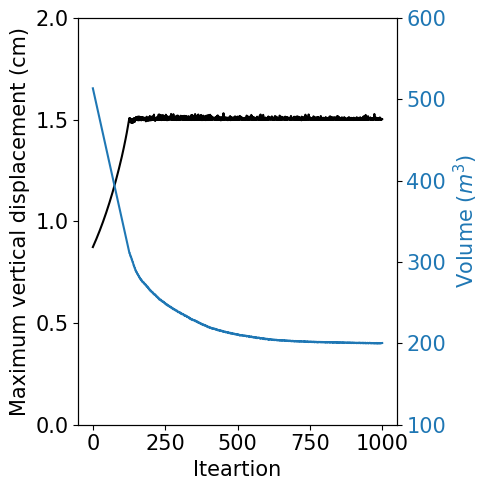

In [22]:
iteration = np.arange(0,len(W_list),1)


fig, ax1 = plt.subplots(figsize=(5,5))

color = 'k'
ax1.set_xlabel('Iteartion',fontsize=15)
ax1.set_ylabel('Maximum vertical displacement (cm)',color=color,fontsize=15)
ax1.plot(iteration, np.array(u_max_list)*100, color=color)
ax1.tick_params(axis='both', labelcolor=color, which='major', labelsize=15)
ax1.set_yticks(np.linspace(0,2,5))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'Volume ($m^3$)', color=color,fontsize=15)  # we already handled the x-label with ax1
ax2.plot(iteration, np.array(W_list)-np.array(pen_list), color=color)
ax2.tick_params(axis='both', labelcolor=color, which='major', labelsize=15)
ax2.set_yticks(np.linspace(100,600,6))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

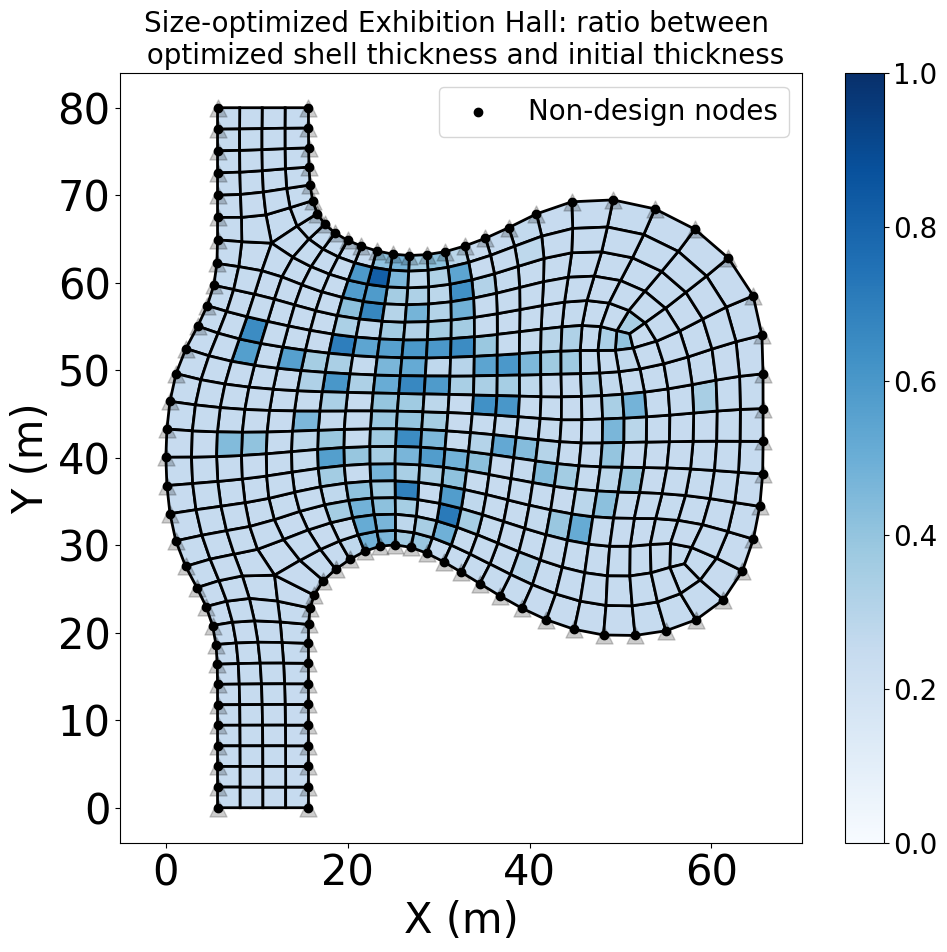

In [24]:

fig,ax = plt.subplots(figsize=(11,10))
plt.xlim(-5,70)
#plt.ylim(-5,30)
plt.title('Size-optimized Exhibition Hall: ratio between \n optimized shell thickness and initial thickness',fontsize=20)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['Blues']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(A_opt[i]/0.2)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()